In [83]:
#Imports
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

In [84]:
#Function to pull in stock data
def stock_data(ticker, start_date, end_date, drop_extra_cols = True):
    try:
        # get ticker object
        ticker_data = yf.Ticker(ticker)
        # fetch data between start date ane end date
        df = ticker_data.history(start=start_date, end=end_date)
        # Drop unnecessary columns
        if len(df) > 0 and drop_extra_cols:
            df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits" ], axis=1)
        return df
    
    except Exception as e:
        print(f"ERROR: An Error occurred while fetching and formatting data for {ticker} from yfinance  \n DETAILS: {repr(e)}")
        raise
        

In [88]:
#Get stock data 
# Calculate daily return and rolling standard deviation
# Generate trading signals, when daily return > 0 that's a buy signal or 1 and when daily return < 0 that's a sell 
#signal or 0
# rolling window should equal the window size 
window = 5
start_date = "2010-03-01"
end_date = "2017-12-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change()
ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std()
ticker_df["Trading Signal"] = 0.0
ticker_df["Trading Signal"] = np.where(
    ticker_df["Daily Return"] > 0, 1.0, 0
)
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return,Rolling Std Dev,Trading Signal
Date,,,,
2010-03-08,22.299732,0.001399,0.009701,1.0
2010-03-09,22.432144,0.005938,0.003408,1.0
2010-03-10,22.564558,0.005903,0.003399,1.0
2010-03-11,22.728130,0.007249,0.003663,1.0
2010-03-12,22.798235,0.003084,0.002397,1.0


In [104]:
#Function that returns numpy array for X and y
def window_data(df, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [105]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using previous returns to predict future returns 
window_size = window

feature_column = 1
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [106]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [107]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [108]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [109]:
#Import the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [110]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [111]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [112]:
# Show the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_30 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 5)                

In [113]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 6ms/step - loss: 0.2392
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1672
Epoch 3/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0891
Epoch 4/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 5/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 6/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 7/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 8/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0178


In [114]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0045165098272264

In [115]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [116]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [119]:
# Create a DataFrame of Real and Predicted values
actual_trading_signal = np.where(
    real_prices.ravel() > 0, 1.0, 0
)
predicted_trading_signal = np.where(
    predicted_prices.ravel() > 0, 1.0, 0
)
stocks = pd.DataFrame({
    "Actual Return": real_prices.ravel(),
    "Predicted Return": predicted_prices.ravel(),
    "Actual Trading Signal": actual_trading_signal,
    "Predicted Trading Signal": predicted_trading_signal
}, index = ticker_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal
Date,,,,
2015-08-28,0.000684,-0.010566,1.0,0.0
2015-08-31,-0.009333,-0.007146,0.0,0.0
2015-09-01,-0.039062,-0.004503,0.0,0.0
2015-09-02,0.036824,-0.001636,1.0,0.0
2015-09-03,0.003229,-0.004634,1.0,0.0
2015-09-04,-0.020459,-0.006614,0.0,0.0
2015-09-08,0.030040,-0.007047,1.0,0.0
2015-09-09,-0.018683,-0.006591,0.0,0.0
2015-09-10,0.005108,-0.003645,1.0,0.0


In [120]:
stocks.tail(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal
Date,,,,
2017-12-15,0.025505,-0.003924,1.0,0.0
2017-12-18,-0.005412,-0.004827,0.0,0.0
2017-12-19,-0.006367,-0.005458,0.0,0.0
2017-12-20,-0.003612,-0.005617,0.0,0.0
2017-12-21,-0.000234,-0.005321,0.0,0.0
2017-12-22,0.000117,-0.004631,1.0,0.0
2017-12-26,-0.001286,-0.006378,0.0,0.0
2017-12-27,0.003630,-0.006230,1.0,0.0
2017-12-28,0.000117,-0.005909,1.0,0.0


In [122]:
# Plot real returns vs predicted returns 
# Using previous returns to predict future returns
#stocks.plot(title="Actual Vs. Predicted Returns")

##Reuse the data and functions to analyze rolling standard deviations ability to predict returns

In [20]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future returns 
std_dev_window = 10
window_size = std_dev_window

feature_column = 2
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [21]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [22]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [23]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [27]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = std_dev_window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [28]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [29]:
# Show the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 10)            840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)               

In [30]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 10ms/step - loss: 0.2052
Epoch 2/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0509
Epoch 3/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0206
Epoch 4/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0161
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0141
Epoch 6/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 7/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 8/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0131
Epoch 9/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0123
Epoch 10/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0119


In [31]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.004264168906956911

In [32]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [33]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [34]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ticker_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head(10)

,Actual,Predicted
Date,,
2015-09-01,-0.039062,0.000305
2015-09-02,0.036824,0.003396
2015-09-03,0.003229,0.005972
2015-09-04,-0.020459,0.008219
2015-09-08,0.030040,0.008982
2015-09-09,-0.018683,0.010224
2015-09-10,0.005108,0.012379
2015-09-11,0.004389,0.011638
2015-09-14,-0.010119,0.010048


In [35]:
stocks.tail(10)

,Actual,Predicted
Date,,
2017-12-15,0.025505,0.001860
2017-12-18,-0.005412,0.002560
2017-12-19,-0.006367,0.001806
2017-12-20,-0.003612,0.001042
2017-12-21,-0.000234,-0.000068
2017-12-22,0.000117,-0.001196
2017-12-26,-0.001286,-0.003000
2017-12-27,0.003630,-0.002572
2017-12-28,0.000117,-0.002245


<AxesSubplot:title={'center':'Actual Vs. Predicted Returns'}, xlabel='Date'>

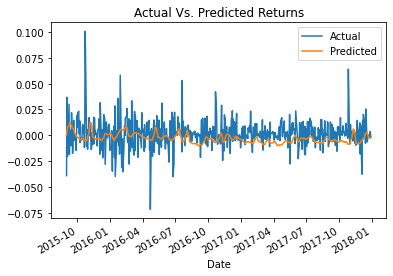

In [36]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
stocks.plot(title="Actual Vs. Predicted Returns")

In [ ]:
#Is there a way to combine rolling standard deviations and price predictions to get at predicted returns 
#to then compare them to actual returns

# Use data and models and previous closing prices to predict prices

In [69]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future returns 
price_window = 10
window_size = price_window

feature_column = 0
target_column = 0
X, y = window_data(ticker_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[22.29973221 22.43214417 22.56455803 22.72813034 22.79823494 22.813797
  22.87612534 23.078619   23.06305122 23.04746819]
 [22.43214417 22.56455803 22.72813034 22.79823494 22.813797   22.87612534
  23.078619   23.06305122 23.04746819 23.05526161]
 [22.56455803 22.72813034 22.79823494 22.813797   22.87612534 23.078619
  23.06305122 23.04746819 23.05526161 23.2733593 ]
 [22.72813034 22.79823494 22.813797   22.87612534 23.078619   23.06305122
  23.04746819 23.05526161 23.2733593  23.09420586]
 [22.79823494 22.813797   22.87612534 23.078619   23.06305122 23.04746819
  23.05526161 23.2733593  23.09420586 23.37461472]] 

y sample values:
[[23.05526161]
 [23.2733593 ]
 [23.09420586]
 [23.37461472]
 [23.10199738]]


In [70]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [71]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [72]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.0675035 ]
  [0.06828391]
  [0.07032543]
  [0.07284734]
  [0.07392819]
  [0.07416812]
  [0.07512908]
  [0.07825108]
  [0.07801106]
  [0.0777708 ]]

 [[0.06958386]
  [0.07032543]
  [0.07284734]
  [0.07392819]
  [0.07416812]
  [0.07512908]
  [0.07825108]
  [0.07801106]
  [0.0777708 ]
  [0.07789096]]

 [[0.07166424]
  [0.07284734]
  [0.07392819]
  [0.07416812]
  [0.07512908]
  [0.07825108]
  [0.07801106]
  [0.0777708 ]
  [0.07789096]
  [0.08125353]]

 [[0.07423417]
  [0.07392819]
  [0.07416812]
  [0.07512908]
  [0.07825108]
  [0.07801106]
  [0.0777708 ]
  [0.07789096]
  [0.08125353]
  [0.07849139]]

 [[0.0753356 ]
  [0.07416812]
  [0.07512908]
  [0.07825108]
  [0.07801106]
  [0.0777708 ]
  [0.07789096]
  [0.08125353]
  [0.07849139]
  [0.08281465]]] 

X_test sample values:
[[[0.38722566]
  [0.37081051]
  [0.35759525]
  [0.32156667]
  [0.30223059]
  [0.28539875]
  [0.3165586 ]
  [0.33311237]
  [0.33352977]
  [0.32782623]]

 [[0.37786979]
  [0.35759525]
  [0.321566

In [73]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = price_window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [74]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [75]:
# Show the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 10)            840       
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 10)            840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 10)               

In [76]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 5s 10ms/step - loss: 0.0181
Epoch 2/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 3/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0147
Epoch 4/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0125
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 6/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 7/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 8/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 9/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 10/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0024


In [77]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.007813028059899807

In [78]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [79]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [80]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ticker_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head(10)

,Actual,Predicted
Date,,
2015-09-01,37.732342,38.572666
2015-09-02,39.121811,37.759018
2015-09-03,39.248131,37.006012
2015-09-04,38.445137,36.405247
2015-09-08,39.600014,36.342468
2015-09-09,38.860176,36.596367
2015-09-10,39.058670,37.155838
2015-09-11,39.230087,37.268784
2015-09-14,38.833099,37.125443


In [81]:
stocks.tail(10)

,Actual,Predicted
Date,,
2017-12-15,82.863663,66.352158
2017-12-18,82.415230,66.234322
2017-12-19,81.890480,66.464020
2017-12-20,81.594727,66.700722
2017-12-21,81.575638,66.871124
2017-12-22,81.585175,67.112602
2017-12-26,81.480217,67.232536
2017-12-27,81.775978,67.269753
2017-12-28,81.785538,67.281319


<AxesSubplot:title={'center':'Actual Vs. Predicted Returns'}, xlabel='Date'>

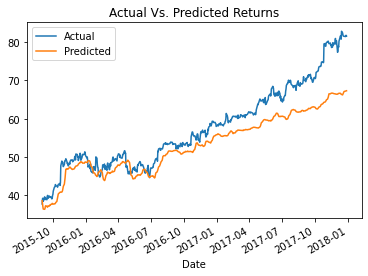

In [82]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
stocks.plot(title="Actual Vs. Predicted Returns")